# Customizing sampling strategy

The default strategy of flowMC looks like the following:

1. In training phase
    1. Sample with local sampler
    2. Train normalizing flow with the samples
    3. Sample with global sampler
2. Freeze the normalizing flow
3. In production phase
    1. Sample with local sampler
    2. Sample with global sampler


One of the major changes introduced in `flowMC` 0.4.0 is the ability to customize the sampling strategy. In this notebook, we will demonstrate how to build your own sampling strategy to sample a Normal distribution when the initialization is very off from the true distribution.

In [1]:
import jax
import jax.numpy as jnp
from flowMC.resource.local_kernel.Gaussian_random_walk import GaussianRandomWalk
from flowMC.resource.buffers import Buffer
from flowMC.strategy.optimization import AdamOptimization
from flowMC.strategy.take_steps import TakeSerialSteps
from flowMC.Sampler import Sampler

import numpy as np


def target_log_prob(x, data):
    return -jnp.sum(x ** 2) / 2

In [9]:
n_chains = 5
n_dims = 2
rng_key = jax.random.PRNGKey(0)
n_steps = 200
step_size = 1

RWMCMC_sampler = GaussianRandomWalk(step_size=step_size)
positions = Buffer("positions", n_chains=n_chains, n_steps=n_steps, n_dims=n_dims)
log_prob = Buffer("log_prob", n_chains=n_chains, n_steps=n_steps, n_dims=1)
acceptance = Buffer("acceptance", n_chains=n_chains, n_steps=n_steps, n_dims=1)
resource = {
    "positions": positions,
    "log_prob": log_prob,
    "acceptance": acceptance,
    "RWMCMC": RWMCMC_sampler,
}

strategy = TakeSerialSteps(
    logpdf=target_log_prob,
    kernel_name="RWMCMC",
    buffer_names=["positions", "log_prob", "acceptance"],
    n_steps=n_steps,
)

nf_sampler = Sampler(
    n_dim=n_dims,
    n_chains=n_chains,
    rng_key=rng_key,
    resources=resource,
    strategies=[strategy],
)

Resources and strategies provided. Ignoring resource strategy bundles.


## Let say our initialization is way off

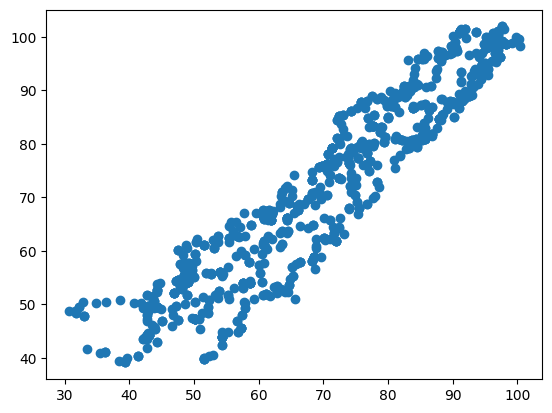

In [10]:
import corner
import matplotlib.pyplot as plt

rng_key, subkey = jax.random.split(rng_key)
# Instead of initializing with a unit gaussian, we initialize with a gaussian with a larger variance
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dims)) + 100

nf_sampler.sample(initial_position, {})

output_chains = nf_sampler.resources["positions"].buffer.reshape(-1, n_dims)
plt.figure()
plt.scatter(output_chains[:, 0], output_chains[:, 1])

We should see the chain need to started off really far from the most probable set. This is not a huge problem for this example since the posterior is rather simple and MALA uses gradient in its proposal. Still, one can see there is a huge jump in the NF loss at some point in the during, basically because the distribution the flow is approximating changes a lot.

Resources and strategies provided. Ignoring resource strategy bundles.
Using Adam optimization


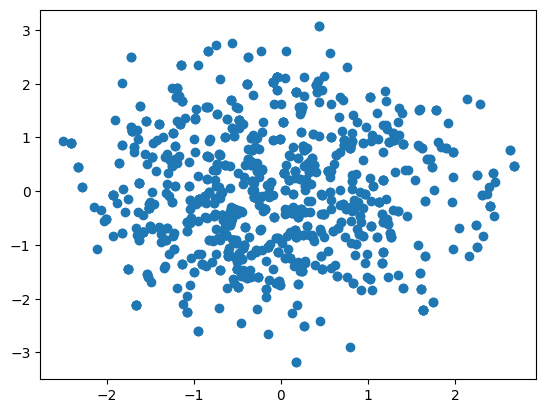

In [13]:
n_opt_steps = 200
learning_rate = 1
noise_level = 0.1
adam_optimizer = AdamOptimization(target_log_prob, n_steps= n_opt_steps,learning_rate=learning_rate, noise_level=noise_level)

positions = Buffer("positions", n_chains=n_chains, n_steps=n_steps, n_dims=n_dims)
log_prob = Buffer("log_prob", n_chains=n_chains, n_steps=n_steps, n_dims=1)
acceptance = Buffer("acceptance", n_chains=n_chains, n_steps=n_steps, n_dims=1)
resource = {
    "positions": positions,
    "log_prob": log_prob,
    "acceptance": acceptance,
    "RWMCMC": RWMCMC_sampler,
}

strategy = TakeSerialSteps(
    logpdf=target_log_prob,
    kernel_name="RWMCMC",
    buffer_names=["positions", "log_prob", "acceptance"],
    n_steps=n_steps,
)

nf_sampler = Sampler(
    n_dim=n_dims,
    n_chains=n_chains,
    rng_key=rng_key,
    resources=resource,
    strategies=[adam_optimizer, strategy],
)

nf_sampler.sample(initial_position, {})

output_chains = nf_sampler.resources["positions"].buffer.reshape(-1, n_dims)
plt.figure()
plt.scatter(output_chains[:, 0], output_chains[:, 1])

Now let's try to run the same example but with an extra step in the sampling strategy: we will run Adam some number of steps before starting the normalizing flow training. This should help the normalizing flow to start closer to the target distribution.

In [ ]:
n_loop_training = 20
n_loop_production = 20
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

Adam_opt = optimization_Adam(n_steps=10000, learning_rate=1, noise_level=1)

rng_key, subkey = jax.random.split(rng_key)
nf_sampler = Sampler(
    n_dim,
    subkey,
    {"data": data},
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
    strategies=[Adam_opt, "default"],
)
print(nf_sampler.strategies)
nf_sampler.sample(initial_position, data={"data": data})

As we can see, the chains are much closer to the target distribution from the start, hence the normalizing flow training is much smoother.

In [ ]:
out_train = nf_sampler.get_sampler_state(training=True)
chains = np.array(out_train["chains"])
global_accs = np.array(out_train["global_accs"])
local_accs = np.array(out_train["local_accs"])
loss_vals = np.array(out_train["loss_vals"])
rng_key, subkey = jax.random.split(rng_key)
nf_samples = np.array(nf_sampler.sample_flow(subkey, 3000))


# Plot 2 chains in the plane of 2 coordinates for first visual check
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], "o-", alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], "o-", alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels = ["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(chains.reshape(-1, n_dim), labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()